## 0. Simulate some data and fit an emulator

In [1]:
import torch

from autoemulate.experimental.simulations.projectile import ProjectileMultioutput
from autoemulate.experimental.emulators.gaussian_process.exact import (
    GaussianProcessExact,
)

In [2]:
sim = ProjectileMultioutput()
x = sim.sample_inputs(100)
y = sim.forward_batch(x)

Running simulations: 100%|██████████| 100/100 [00:00<00:00, 1028.39it/s]

Successfully completed 100/100 simulations (100.0%)


In [3]:
gp = GaussianProcessExact(x, y)
gp.fit(x, y)

## 1. Simple HMC example.

In [4]:
from autoemulate.experimental.calibration.hmc import HMCCalibrator

Lets start with an observation inside the training range, we should be able to recover the input parameters.

In other words, just pick as observation one row of our simulated values.

In [5]:
idx = 4
observations = {"distance": y[idx, 0], "impact_velocity": y[idx:idx+1, 1]}
observations

{'distance': tensor(702.7261, dtype=torch.float64),
 'impact_velocity': tensor([48.6903], dtype=torch.float64)}

In [6]:
# use the simulator parameter_range 
hmc = HMCCalibrator(gp, sim.parameters_range, observations, 1.0)

Run MCMC (note that below we have set the number of MCMC steps to a very low number, don't expect convergence).

In [7]:
mcmc = hmc.run(warmup_steps=10, num_samples=100)

Sample: 100%|██████████| 110/110 [00:04, 22.66it/s, step size=7.03e-04, acc. prob=0.432]


The returned Pyro MCMC object has methods for accessing the generated samples (`mcmc.get_samples()`) or, as shown below, to get just their summary statistics.

In [8]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c     -1.36      0.12     -1.36     -1.54     -1.19      2.74      2.28
        v0    391.96      2.08    391.56    388.97    393.36      9.79      1.14

Number of divergences: 100


## 2. Plotting with Arviz

We have an option to turn mcmc into an Arviz object. One can then pass this all the Arviz plotting functions.

In [9]:
import arviz as az

In [10]:
az_data = hmc.to_arviz(mcmc, posterior_predictive=True)

/Users/rjersakova/Documents/Projects/autoemulate/.venv/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([[<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>]],
      dtype=object)

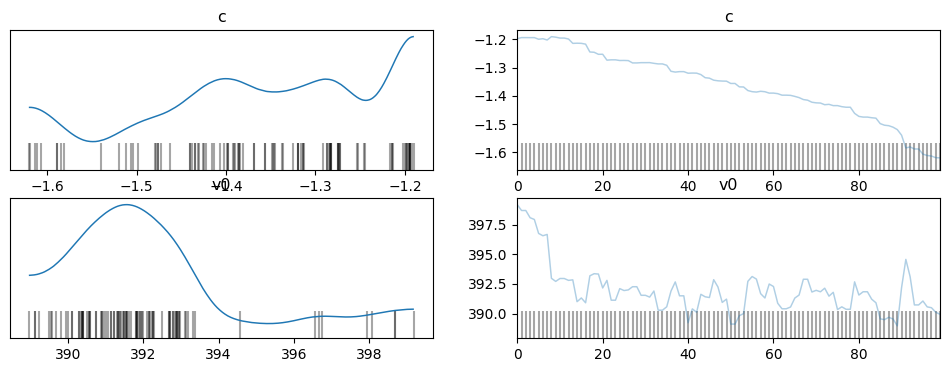

In [11]:
az.plot_trace(az_data)

<Axes: xlabel='c', ylabel='v0'>

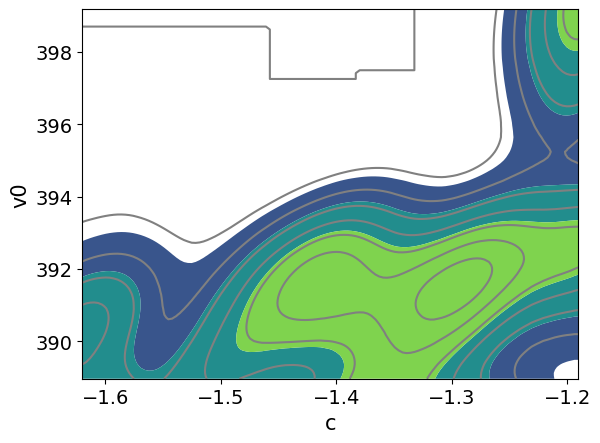

In [12]:
# we only have 2 params
az.plot_pair(az_data, kind='kde')

array([<Axes: xlabel='distance'>, <Axes: xlabel='impact_velocity'>],
      dtype=object)

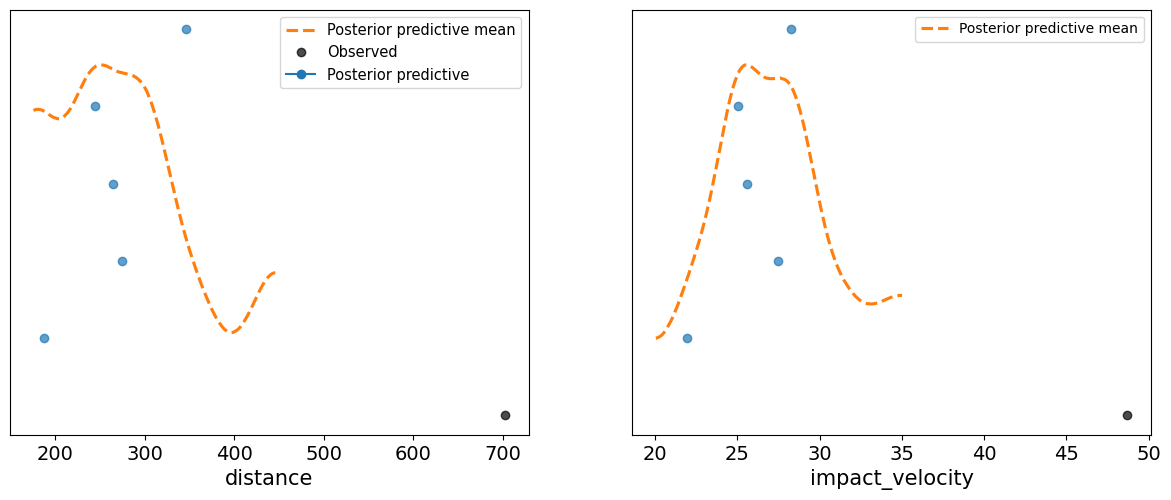

In [13]:
az.plot_ppc(az_data, kind='scatter')
# hmc.posterior_predictive(mcmc).values()

## 3. Using sensitivity analysis and history matching to refine problem before running HMC.

The `HMCCalibrator` object has an option to provide a list of parameters to calibrate. A common approach is to select these based on results of `SensitivityAnalysis`.

Similarly, the user provides parameter ranges from which to sample or set the parameter values. This can be simply the range of the simulator or one can use `HistoryMatching` to reduce the parameter range and pass that to the `HMCCalibrator` instead. 

Below we demonstrate how to do both.

In [14]:
from autoemulate.experimental.sensitivity_analysis import SensitivityAnalysis
from autoemulate.experimental.calibration.history_matching import HistoryMatching

1. Run sensitivity analysis and get top N parameters (here we just get the top 1).

In [15]:
problem = {
        "num_vars": 2,
        "names": sim.param_names,
        "bounds": sim.param_bounds,
    }
sa = SensitivityAnalysis(gp, problem=problem)
df = sa.run("sobol")

/Users/rjersakova/Documents/Projects/autoemulate/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/rjersakova/Documents/Projects/autoemulate/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Notice that the output is just a list of strings, the user does not need to run SA to set a subset of parameters to calibrate.

In [16]:
top_param = sa.top_n_sobol_params(df, 1)
top_param

['c']

2. Run history matching and generate new parameter bounds from NROY samples.

In [17]:
# start with some GP predictions
x_new = sim.sample_inputs(20)
output = gp.predict(torch.tensor(x_new, dtype=torch.float32))
pred_means, pred_vars = (
    output.mean.float().detach(),
    output.variance.float().detach(),
)

/var/folders/bj/kdwy1bhj3h728lr5xdj19yd40000gr/T/ipykernel_787/3687513851.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = gp.predict(torch.tensor(x_new, dtype=torch.float32))


In [18]:
# generate NROY samples
hm = HistoryMatching(
    # add noise to observations
    observations={k: [v, 10.0] for k,v in observations.items()},
    threshold=5.0,
    rank=2
)
implausability = hm.calculate_implausibility(pred_means, pred_vars)
nroy_samples = hm.get_nroy(implausability, x_new)
nroy_samples

tensor([[ -2.2236, 367.0691],
        [ -4.7312, 974.4691],
        [ -2.3498, 572.9030],
        [ -1.5840, 862.6241]])

The newly generated range is slightly narrower than the range of the simulator.

In [19]:
# get new param bounds
nroy_param_range = hm.generate_param_bounds(nroy_samples, param_names = sim.param_names)
nroy_param_range

{'c': (-4.8885602951049805, -1.42659592628479),
 'v0': (336.6991271972656, 1004.839111328125)}

3. Pass results to the HMCCalibrator object.

In [20]:
hmc_nroy = HMCCalibrator(
    gp, 
    nroy_param_range if nroy_param_range is not None else sim.parameters_range, 
    observations, 
    1.0,
    top_param
    )

In [22]:
mcmc_nroy = hmc_nroy.run(warmup_steps=10, num_samples=100)

In [ ]:
mcmc_nroy.summary()